# Práctica 4: Clasificación de vuelos

La cuarta práctica consiste en realizar una tarea de **clasificación** para predecir los estados de los vuelos con datos históricos reales. El dataset provisto deberá ser analizado respecto a los siguientes requerimientos:

*   Limpieza de datos.
*   Análisis exploratorio de los datos.
*   Procesamiento de datos.
*   Extracción y selección de características.
*   Reducción de dimensionalidad.
*   Evaluación 'interna' con al menos 10 algoritmos de inferencia.
*   Reportar los resultados con las siguientes métricas: (i) F1-score macro, (ii) sensibilidad, y (iii) especificidad; además de mostrar las respectivas matrices de confusión.

Dado que el tema central de la unidad es la clasificación automática, se deberán evaluar exhaustivamente los siguientes algoritmos **shallow** (no utilizar algoritmos basados en aprendizaje profundo):

*   Aprendizaje basado en árboles de decisión (e.g. C4.5)
*   Aprendizaje Bayesiano (e.g. Naive Bayes)
*   Aprendizaje basado en instancias (e.g. kNN)
*   Máquinas de soporte vectorial (SVM)
*   Seis algoritmos de inferencia adicionales.

La evaluación sumativa estará enmarcada en un **challenge** de programación grupal, para lo cual la segunda etapa consistirá en validar el mejor modelo generado individualmente con un dataset de prueba (sin las respectivas etiquetas), el cual será compartido un día antes del **deadline**. Deberá subirse un archivo con las etiquetas predichas por su mejor modelo con el formato que les será compartido más adelante. Se espera que las evaluaciones 'locales' se realicen utilizando una partición del conjunto de entrenamiento, y validación cruzada. Además de la calificación asociada a la práctica se otorgarán puntos adicionales que se sumarán a la calificación final del curso, de la siguiente forma:

*   1er lugar: 3 puntos
*   2do lugar: 2 puntos
*   3er, 4to y 5to lugar: 1 punto

Además, se otorgará un 1 punto adicional para todos los estudiantes que superen el **baseline** proporcionado.

## Descripción del conjunto de datos

El conjunto de datos contiene 14 atributos, cuya descripción es la siguiente:

*   **FL\_DATE**: Fecha del vuelo
*   **OP\_CARRIER**: Identificador de la aerolínea
*   **OP\_CARRIER\_FL\_NUM**: Número de vuelo
*   **ORIGIN**: Código del aeropuerto de origen
*   **DEST**: Código del aeropuerto de destino
*   **CRS\_DEP\_TIME**: Hora planeada de salida
*   **DEP\_TIME**: Hora actual de salida
*   **DEP\_DELAY**: Retraso en la salida en minutos
*   **TAXI\_OUT**: El tiempo transcurrido entre la salida desde el aeropuerto de origen y el atributo "WHEELS\_OFF"
*   **WHEELS\_OFF**: Hora a la que las llantas del avión dejaron de tocar el suelo
*   **CRS\_ARR\_TIME**: Hora planeada de llegada
*   **ARR\_DELAY**: Retraso total en la llegada en minutos (atributo a predecir)
*   **CRS\_ELAPSED\_TIME**: Tiempo total planeado del vuelo
*   **DISTANCE**: Distancia entre los dos aeropuertos

## Tarea

La tarea a realizar es predecir con anticipación si un vuelo se va a retrasar, llegará antes o llegará a tiempo (pocos momentos después de que despegue), por lo que el atributo a predecir es "ARR\_DELAY". Sin embargo, como esta variable está en minutos, se deberá realizar un preprocesamiento de los datos para transformarla en las siguientes clases:

*   **Early**: Cuando el avión llega más de 15 minutos antes de la hora planeada de llegada.
*   **Delay**: Cuando el avión llega más de 15 minutos después de la hora planeada de llegada.
*   **On time**: Cuando el avión llega ±15 minutos de la hora planeada de llegada.

## Métrica de evaluación

La métrica que se utilizará para decidir las posiciones será el F1-score macro.


In [1]:
# Para la manipulación de datos: leer, procesar y transformar datos tabulares.
import pandas as pd

# Para la visualización básica de datos: crear gráficos estáticos, interactivos y animados.
import matplotlib.pyplot as plt

# Para la visualización estadística:  gráficos más atractivos e informativos basados en matplotlib.
import seaborn as sns

# Para operaciones numéricas:  arreglos multidimensionales y funciones matemáticas.
import numpy as np

# Para dividir los datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split, cross_val_score

# Métricas para evaluar el rendimiento del modelo.
from sklearn.metrics import f1_score, confusion_matrix, precision_score, accuracy_score, recall_score
    # f1_score: media armónica entre precisión y recall, balance entre ambos.
    # confusion_matrix: matriz que describe el rendimiento de un modelo de clasificación (VP, FP, VN, FN).
    # precision_score: proporción de predicciones positivas correctas (precisión).
    # accuracy_score: precisión general del modelo (proporción de predicciones correctas).

# Para calcular la entropía de una distribución de probabilidad.
from scipy.stats import entropy

# Para guardar (serializar) y cargar (deserializar) modelos entrenados.
import pickle

# Selección de características:  identificar las características más relevantes para el modelo

# Técnicas para seleccionar características.
from sklearn.feature_selection import chi2, SelectKBest
    # chi2: calcula la prueba chi-cuadrado para determinar la independencia entre variables categóricas.
    # SelectKBest: selecciona las k mejores características según una función de puntuación (e.g., chi2).

# Modelo lineal con regularización L1 para la selección de características, encogiendo coeficientes a cero.
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Algoritmos de aprendizaje automático (clasificación)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Análisis de componentes principales (reducción de dimensionalidad).
from sklearn.decomposition import PCA

In [46]:
df = pd.read_csv("Practica 4 train_airlines_delay_challenge.csv")

# 1. Limpieza de datos


In [5]:
print(df.isnull().sum())

FL_DATE              0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
CRS_DEP_TIME         0
DEP_TIME             0
DEP_DELAY            0
TAXI_OUT             0
WHEELS_OFF           0
CRS_ARR_TIME         0
ARR_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64


In [47]:
df.drop_duplicates(inplace=True)

In [48]:
def categorize_delay(delay):
    if delay < -15:
        return "Early"
    elif delay > 15:
        return "Delay"
    else:
        return "On time"

df['ARR_DELAY_CATEGORY'] = df['ARR_DELAY'].apply(categorize_delay)

df.drop(['ARR_DELAY'], axis=1, inplace=True)

# 2. Análisis exploratorio de datos


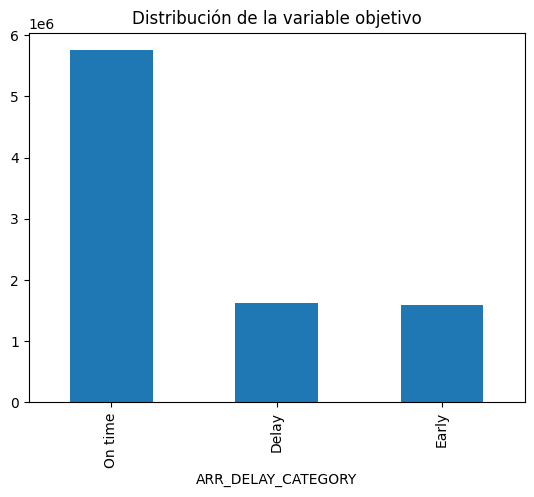

In [30]:
# 1. Distribución de la variable objetivo
target_distribution = df['ARR_DELAY_CATEGORY'].value_counts()
target_distribution.plot(kind='bar', title='Distribución de la variable objetivo')
plt.show()

In [11]:
df.shape

(8972478, 14)

In [12]:
df.head(15)

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_CATEGORY
0,2009-09-05,AA,2062,MIA,BOS,1055.0,1139.0,44.0,15.0,1154.0,1405.0,190.0,1258.0,Delay
1,2009-05-08,XE,2926,IAH,ELP,2115.0,2112.0,-3.0,17.0,2129.0,2219.0,124.0,667.0,On time
2,2009-03-16,OH,6433,CVG,DSM,1430.0,1425.0,-5.0,25.0,1450.0,1518.0,108.0,505.0,On time
3,2009-03-04,OO,5439,LAX,SBA,820.0,814.0,-6.0,15.0,829.0,905.0,45.0,89.0,On time
4,2009-06-12,WN,615,LAS,MCI,1235.0,1234.0,-1.0,13.0,1247.0,1735.0,180.0,1140.0,Early
5,2009-08-04,WN,94,OAK,PHX,600.0,603.0,3.0,9.0,612.0,805.0,125.0,646.0,On time
6,2009-06-04,EV,5421,FAY,ATL,1633.0,1653.0,20.0,8.0,1701.0,1754.0,81.0,331.0,Delay
7,2009-11-21,AA,489,RSW,DFW,1235.0,1235.0,0.0,12.0,1247.0,1435.0,180.0,1017.0,On time
8,2009-04-25,YV,7328,LGA,IAD,601.0,556.0,-5.0,9.0,605.0,719.0,78.0,229.0,Early
9,2009-11-16,NW,2353,DTW,SFO,1550.0,1550.0,0.0,33.0,1623.0,1820.0,330.0,2079.0,Early


In [13]:
 df.describe()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE
count,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06,8.972478e+06
mean,2.245609e+03,1.326131e+03,1.332793e+03,8.892802e+00,1.581471e+01,1.355607e+03,1.495591e+03,1.368963e+02,7.891141e+02
std,1.877002e+03,4.730424e+02,4.856459e+02,3.605952e+01,9.185591e+00,4.869795e+02,4.932918e+02,7.356862e+01,5.948564e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,-2.340000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01,3.100000e+01
25%,6.970000e+02,9.220000e+02,9.250000e+02,-5.000000e+00,1.000000e+01,9.390000e+02,1.115000e+03,8.400000e+01,3.540000e+02
50%,1.685000e+03,1.320000e+03,1.327000e+03,-2.000000e+00,1.400000e+01,1.340000e+03,1.520000e+03,1.180000e+02,6.220000e+02
75%,3.467000e+03,1.725000e+03,1.733000e+03,7.000000e+00,1.800000e+01,1.747000e+03,1.911000e+03,1.680000e+02,1.020000e+03
max,9.320000e+03,2.359000e+03,2.400000e+03,1.805000e+03,2.970000e+02,2.400000e+03,2.400000e+03,7.180000e+02,4.983000e+03


Se tienen 8,972,478 muestras y 14 atributos, donde uno de ellos es la fecha, lo que permite extraer varias características, como el mes, el día de la semana y la estación del año. Los atributos con datos negativos son muy importantes a la hora de utilizar métodos como Chi-cuadrado, SVM, kNN y regresión logística.

# 3. Extracción de Características

In [5]:
def new_feature(df):

  def get_season(month):
    if month in [12, 1, 2]:
      return 1
    elif month in [3, 4, 5]:
      return 2
    elif month in [6, 7, 8]:
      return 3
    else:
      return 4


  df['DISTANCE_CATEGORY'] = pd.cut(df['DISTANCE'], bins=10, labels=np.arange(10))
  df['CRS_DEP_TIME_CATEGORY'] = pd.cut(df['CRS_DEP_TIME'], bins=10, labels=np.arange(10))


  # Extract day of the week, month, and season from FL_DATE
  df['DAY_OF_WEEK'] = pd.to_datetime(df['FL_DATE']).dt.day_name()
  df['MONTH'] = pd.to_datetime(df['FL_DATE']).dt.month

  # Calculate airline frequency
  airline_freq = df['OP_CARRIER'].value_counts().to_dict()
  df['AIRLINE_FREQ'] = df['OP_CARRIER'].map(airline_freq)

  # Calculate average delay per airline
  avg_delay_airline = df.groupby('OP_CARRIER')['DEP_DELAY'].mean().to_dict()
  df['AVG_DELAY_AIRLINE'] = df['OP_CARRIER'].map(avg_delay_airline)

  # Calculate average delay per origin airport
  avg_delay_origin = df.groupby('ORIGIN')['DEP_DELAY'].mean().to_dict()
  df['AVG_DELAY_ORIGIN'] = df['ORIGIN'].map(avg_delay_origin)

  # Calculate average delay per destination airport
  avg_delay_dest = df.groupby('DEST')['DEP_DELAY'].mean().to_dict()
  df['AVG_DELAY_DEST'] = df['DEST'].map(avg_delay_dest)

  # Combine origin and destination
  df['ORIG_DEST'] = df['ORIGIN'] + '_' + df['DEST']

  # Calculate average speed
  df['AVG_SPEED'] = df['DISTANCE'] / df['CRS_ELAPSED_TIME']

  df['SEASON'] = df['MONTH'].apply(get_season)

  df['TIME_DELAY'] = df['DEP_TIME'] + df['TAXI_OUT']
  return df

In [49]:
new_feature(df)

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,DAY_OF_WEEK,MONTH,AIRLINE_FREQ,AVG_DELAY_AIRLINE,AVG_DELAY_ORIGIN,AVG_DELAY_DEST,ORIG_DEST,AVG_SPEED,SEASON,TIME_DELAY
0,2009-09-05,AA,2062,MIA,BOS,1055.0,1139.0,44.0,15.0,1154.0,...,Saturday,9,961662,9.391242,11.121271,10.175969,MIA_BOS,6.621053,4,1154.0
1,2009-05-08,XE,2926,IAH,ELP,2115.0,2112.0,-3.0,17.0,2129.0,...,Friday,5,172356,8.465090,9.401652,10.469574,IAH_ELP,5.379032,2,2129.0
2,2009-03-16,OH,6433,CVG,DSM,1430.0,1425.0,-5.0,25.0,1450.0,...,Monday,3,45439,10.152644,8.407695,9.983631,CVG_DSM,4.675926,2,1450.0
3,2009-03-04,OO,5439,LAX,SBA,820.0,814.0,-6.0,15.0,829.0,...,Wednesday,3,908531,7.583065,9.240188,7.169626,LAX_SBA,1.977778,2,829.0
4,2009-06-12,WN,615,LAS,MCI,1235.0,1234.0,-1.0,13.0,1247.0,...,Friday,6,1792890,10.775900,9.841492,9.959219,LAS_MCI,6.333333,3,1247.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999995,2017-10-27,WN,4233,PDX,SMF,2025.0,2022.0,-3.0,11.0,2033.0,...,Friday,10,1792890,10.775900,5.098405,8.942933,PDX_SMF,5.635294,4,2033.0
8999996,2017-01-06,OO,4482,SEA,SMF,2105.0,2113.0,8.0,23.0,2136.0,...,Friday,1,908531,7.583065,5.826550,8.942933,SEA_SMF,5.000000,1,2136.0
8999997,2017-09-24,WN,3997,DEN,SNA,1400.0,1436.0,36.0,11.0,1447.0,...,Sunday,9,1792890,10.775900,10.330997,6.111612,DEN_SNA,6.042857,4,1447.0
8999998,2017-07-28,AS,829,SAN,OGG,720.0,720.0,0.0,10.0,730.0,...,Friday,7,237129,1.509954,7.299037,2.394101,SAN_OGG,7.137640,3,730.0


# 4. Procesamiento de datos



In [50]:
# Diccionario para guardar los encoders
encoders = {}

# Apply label encoding to each categorical column
for col in ['OP_CARRIER', 'ORIGIN', 'DEST', 'ARR_DELAY_CATEGORY','DISTANCE_CATEGORY', 'CRS_DEP_TIME_CATEGORY', 'DAY_OF_WEEK','ORIG_DEST']:
    # Create a LabelEncoder instance
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    encoders[col] = label_encoder
# Drop the 'FL_DATE' column
df.drop(['FL_DATE'], axis=1, inplace=True)

df.info()
# Guardar los encoders en un archivo
with open('encoders.pkl', 'wb') as f:
  pickle.dump(encoders, f)



<class 'pandas.core.frame.DataFrame'>
Index: 8972478 entries, 0 to 8999999
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   OP_CARRIER             int32  
 1   OP_CARRIER_FL_NUM      int64  
 2   ORIGIN                 int32  
 3   DEST                   int32  
 4   CRS_DEP_TIME           float64
 5   DEP_TIME               float64
 6   DEP_DELAY              float64
 7   TAXI_OUT               float64
 8   WHEELS_OFF             float64
 9   CRS_ARR_TIME           float64
 10  CRS_ELAPSED_TIME       float64
 11  DISTANCE               float64
 12  ARR_DELAY_CATEGORY     int32  
 13  DISTANCE_CATEGORY      int64  
 14  CRS_DEP_TIME_CATEGORY  int64  
 15  DAY_OF_WEEK            int32  
 16  MONTH                  int32  
 17  AIRLINE_FREQ           int64  
 18  AVG_DELAY_AIRLINE      float64
 19  AVG_DELAY_ORIGIN       float64
 20  AVG_DELAY_DEST         float64
 21  ORIG_DEST              int32  
 22  AVG_SPEED              

In [51]:
cols_with_negatives = ['DEP_DELAY', 'AVG_DELAY_AIRLINE', 'AVG_DELAY_ORIGIN', 'AVG_DELAY_DEST', 'TIME_DELAY']
scaler = MinMaxScaler()
df[cols_with_negatives] = scaler.fit_transform(df[cols_with_negatives])


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8972478 entries, 0 to 8999999
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   OP_CARRIER             int64  
 1   OP_CARRIER_FL_NUM      int64  
 2   ORIGIN                 int64  
 3   DEST                   int64  
 4   CRS_DEP_TIME           float64
 5   DEP_TIME               float64
 6   DEP_DELAY              float64
 7   TAXI_OUT               float64
 8   WHEELS_OFF             float64
 9   CRS_ARR_TIME           float64
 10  CRS_ELAPSED_TIME       float64
 11  DISTANCE               float64
 12  ARR_DELAY_CATEGORY     int64  
 13  DISTANCE_CATEGORY      int64  
 14  CRS_DEP_TIME_CATEGORY  int64  
 15  DAY_OF_WEEK            int64  
 16  MONTH                  int32  
 17  AIRLINE_FREQ           int64  
 18  AVG_DELAY_AIRLINE      float64
 19  AVG_DELAY_ORIGIN       float64
 20  AVG_DELAY_DEST         float64
 21  ORIG_DEST              int64  
 22  AVG_SPEED              

In [52]:
# Optimizando los tipos de datos para cada columna para minimizar el uso de memoria sin pérdida de datos.
for col in df.columns:
    col_type = df[col].dtype
    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    else:
      df[col] = df[col].astype("category")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8972478 entries, 0 to 8999999
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   OP_CARRIER             int8   
 1   OP_CARRIER_FL_NUM      int16  
 2   ORIGIN                 int16  
 3   DEST                   int16  
 4   CRS_DEP_TIME           float16
 5   DEP_TIME               float16
 6   DEP_DELAY              float16
 7   TAXI_OUT               float16
 8   WHEELS_OFF             float16
 9   CRS_ARR_TIME           float16
 10  CRS_ELAPSED_TIME       float16
 11  DISTANCE               float16
 12  ARR_DELAY_CATEGORY     int8   
 13  DISTANCE_CATEGORY      int8   
 14  CRS_DEP_TIME_CATEGORY  int8   
 15  DAY_OF_WEEK            int8   
 16  MONTH                  int8   
 17  AIRLINE_FREQ           int32  
 18  AVG_DELAY_AIRLINE      float16
 19  AVG_DELAY_ORIGIN       float16
 20  AVG_DELAY_DEST         float16
 21  ORIG_DEST              int16  
 22  AVG_SPEED              

 De 1.7 GB bajo a 453.5 MB

#5. Selección de Características

In [22]:
### Applying feature selection method
correlation_matrix = df.corr()
corr_with_target = correlation_matrix["ARR_DELAY_CATEGORY"].drop("ARR_DELAY_CATEGORY")
# Sort and show features by absolute correlation value
sorted_corr = corr_with_target.abs().sort_values(ascending=False)
print(f"Absolute Correlations with the Objective (ARR_DELAY_CATEGORY):\n{sorted_corr}")

# Define a threshold for correlation (e.g., keep features with |correlation| > 0.2)
threshold = 0.1
selected_features_corr = sorted_corr[sorted_corr > threshold].index.tolist()
print(f"Selected features are: {selected_features_corr}")

Absolute Correlations with the Objective (ARR_DELAY_CATEGORY):
DEP_DELAY                0.496738
TAXI_OUT                 0.186008
TIME_DELAY               0.159586
DEP_TIME                 0.156155
WHEELS_OFF               0.155840
CRS_DEP_TIME             0.116106
CRS_DEP_TIME_CATEGORY    0.115124
CRS_ARR_TIME             0.110999
CRS_ELAPSED_TIME         0.088223
AVG_DELAY_DEST           0.082149
AVG_DELAY_ORIGIN         0.076647
DISTANCE                 0.071396
DISTANCE_CATEGORY        0.070184
AVG_DELAY_AIRLINE        0.058086
SEASON                   0.039101
AVG_SPEED                0.031685
OP_CARRIER               0.028939
AIRLINE_FREQ             0.024329
MONTH                    0.013629
OP_CARRIER_FL_NUM        0.010470
DAY_OF_WEEK              0.009491
ORIGIN                   0.009306
ORIG_DEST                0.009275
DEST                     0.002196
Name: ARR_DELAY_CATEGORY, dtype: float64
Selected features are: ['DEP_DELAY', 'TAXI_OUT', 'TIME_DELAY', 'DEP_TIME', 'WHEE

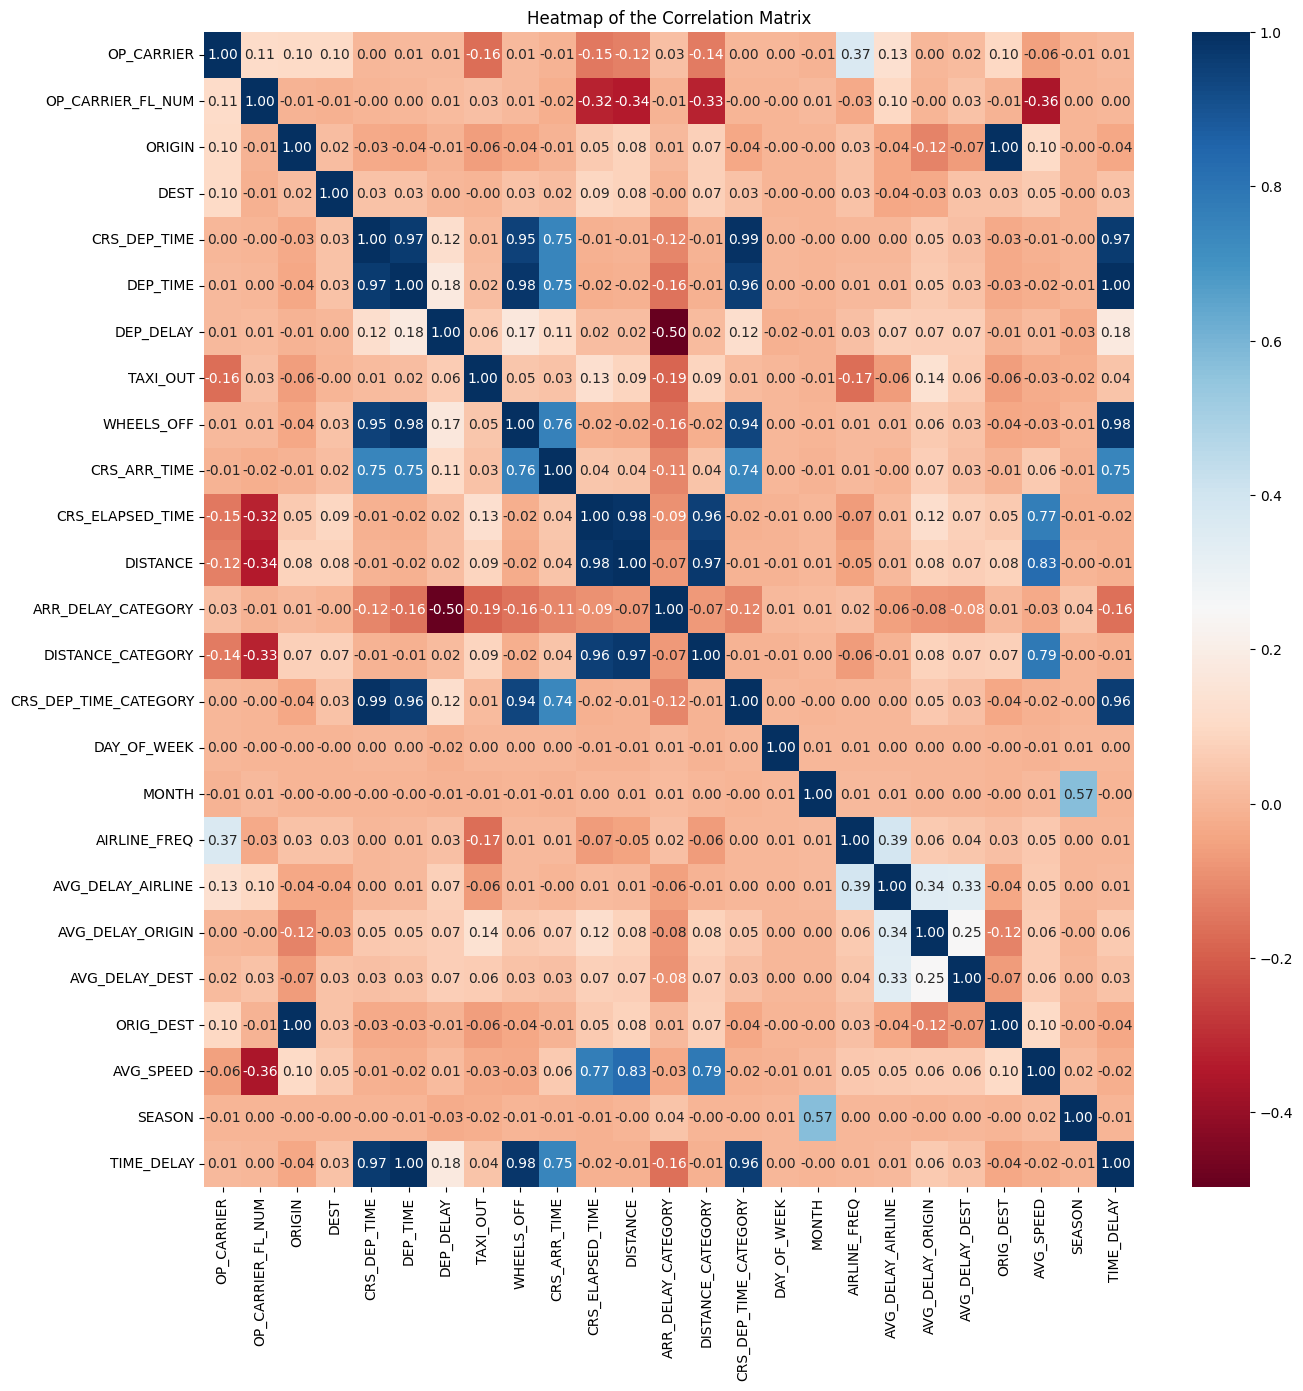

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap using seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt=".2f")

# Set the title of the plot
plt.title('Heatmap of the Correlation Matrix')

# Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e+06, tolerance: 5.473e+02
  model = cd_fast.enet_coordinate_descent(


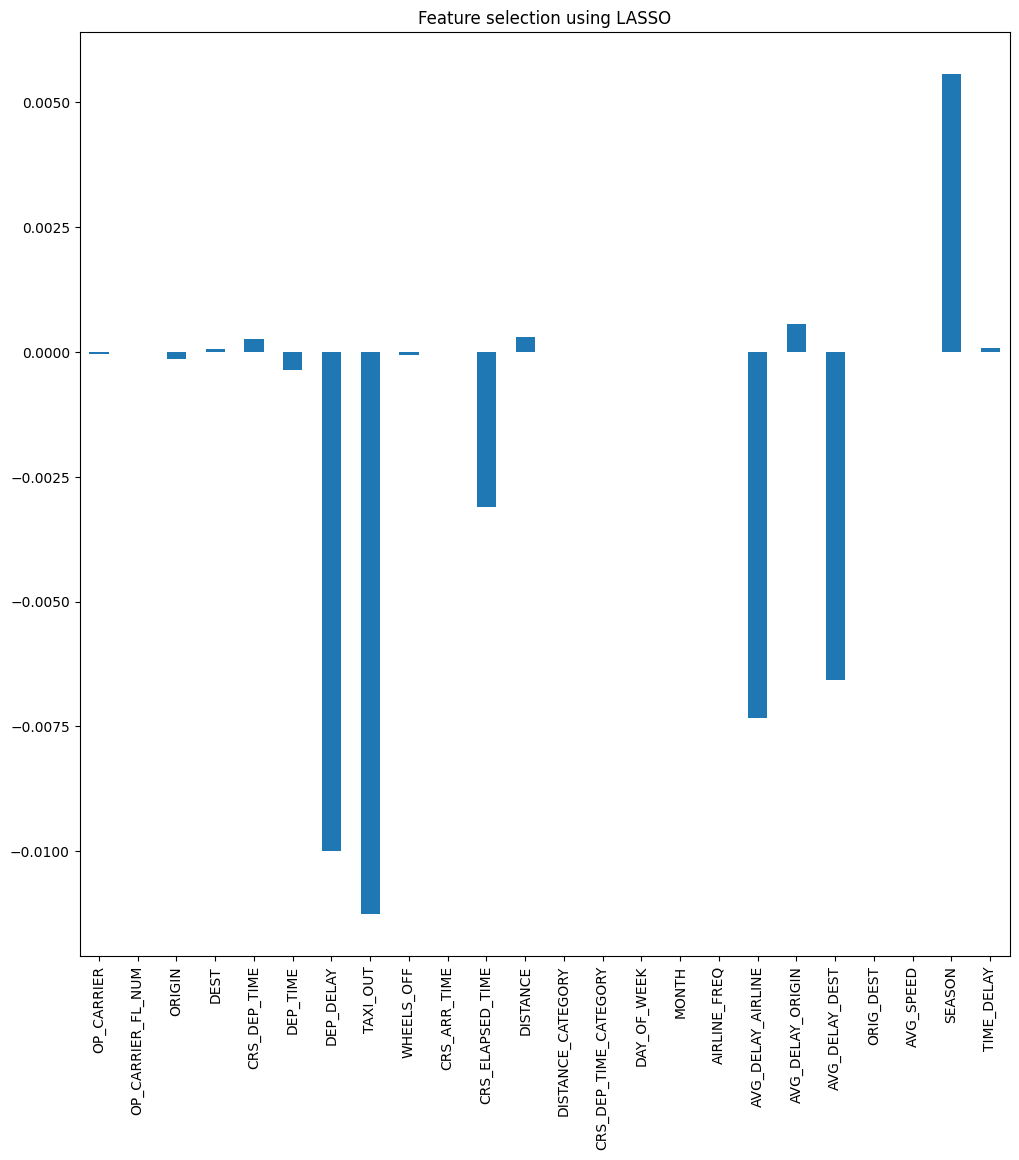

Features sorted by importance: ['TAXI_OUT' 'DEP_DELAY' 'AVG_DELAY_AIRLINE' 'AVG_DELAY_DEST' 'SEASON'
 'CRS_ELAPSED_TIME' 'AVG_DELAY_ORIGIN' 'DEP_TIME' 'DISTANCE'
 'CRS_DEP_TIME' 'ORIGIN' 'TIME_DELAY' 'WHEELS_OFF' 'DEST' 'OP_CARRIER'
 'OP_CARRIER_FL_NUM' 'CRS_ARR_TIME' 'ORIG_DEST' 'AIRLINE_FREQ'
 'DISTANCE_CATEGORY' 'CRS_DEP_TIME_CATEGORY' 'DAY_OF_WEEK' 'MONTH'
 'AVG_SPEED']


In [24]:
X = df.drop(['ARR_DELAY_CATEGORY'], axis=1)
y = df['ARR_DELAY_CATEGORY']

lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

# show feature selection
lasso_coef = pd.Series(lasso.coef_, index=X.columns)

plt.figure(figsize=(12, 12))
lasso_coef.plot(kind='bar')
plt.title('Feature selection using LASSO')
plt.show()

# Get the features sorted by importance.
importance = np.abs(lasso.coef_)
sorted_features = np.array(X.columns)[np.argsort(importance)[::-1]]

# Print the sorted features.
print("Features sorted by importance:", sorted_features)

del X, y, lasso, lasso_coef

In [14]:
X = df.drop(columns=['ARR_DELAY_CATEGORY'])
y = df['ARR_DELAY_CATEGORY']

# Aplicar chi2 para obtener las puntuaciones chi-cuadrado y los p-valores
chi2_scores, p_values = chi2(X, y)

# Crear un DataFrame con los resultados
chi2_results = pd.DataFrame({'feature': X.columns, 'chi2_score': chi2_scores, 'p_value': p_values})

# Ordenar por puntuación chi-cuadrado descendente
chi2_results = chi2_results.sort_values(by=['chi2_score'], ascending=False)

print(chi2_results.head(-1))

del X, y

                  feature    chi2_score        p_value
16           AIRLINE_FREQ  6.449905e+09   0.000000e+00
11               DISTANCE  6.701512e+07   0.000000e+00
8              WHEELS_OFF  5.598702e+07   0.000000e+00
5                DEP_TIME  5.577023e+07   0.000000e+00
4            CRS_DEP_TIME  2.903858e+07   0.000000e+00
9            CRS_ARR_TIME  2.345129e+07   0.000000e+00
1       OP_CARRIER_FL_NUM  1.139416e+07   0.000000e+00
10       CRS_ELAPSED_TIME  9.164253e+06   0.000000e+00
7                TAXI_OUT  3.528230e+06   0.000000e+00
20              ORIG_DEST  8.974627e+05   0.000000e+00
12      DISTANCE_CATEGORY  2.056677e+05   0.000000e+00
0              OP_CARRIER  1.505728e+05   0.000000e+00
13  CRS_DEP_TIME_CATEGORY  1.358092e+05   0.000000e+00
2                  ORIGIN  4.911709e+04   0.000000e+00
3                    DEST  2.400865e+04   0.000000e+00
23             TIME_DELAY  2.297766e+04   0.000000e+00
6               DEP_DELAY  8.317089e+03   0.000000e+00
21        

mejores features en convinacion lasso, chi2 y corr

In [53]:
features = ['TAXI_OUT', 'DEP_DELAY', 'AVG_DELAY_AIRLINE','AVG_DELAY_DEST', 'SEASON', 'CRS_ELAPSED_TIME', 'AVG_DELAY_ORIGIN', 'DEP_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'ORIGIN']

In [54]:
y = df['ARR_DELAY_CATEGORY']
df = df[features]
X = df

# 6. Evaluación "interna" con al menos 10 algoritmos de inferencia sin reducción de dimensionalidad

In [12]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    sensibilidad = recall_score(y_test, y_pred, average='macro')
    especificidad = precision_score(y_test, y_pred, average='macro')
    matriz_confusion = confusion_matrix(y_test, y_pred)
    #scores = cross_val_score(model, X_train, y_train, cv=5)
    return {
        'f1_macro': f1,
        'sensibilidad': sensibilidad,
        'especificidad': especificidad,
        'matriz_confusion': matriz_confusion
    }

In [13]:
modelos = {
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=50, criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None),
    'Naive Bayes Gaussian': GaussianNB(priors=None, var_smoothing=1e-09),
    'Logistic Regression': LogisticRegression(penalty='l2',  dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=1000, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=-1, l1_ratio=None),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=None, n_components=None, store_covariance=False, tol=0.0001, covariance_estimator=None),
    'LinearSVM' : LinearSVC(penalty='l2', loss='squared_hinge', dual='auto', tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000),
    'kNN': KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1),
    'Naive Bayes Multinomial': MultinomialNB(alpha=10.0, force_alpha=True, fit_prior=True, class_prior=None),
    'RidgeClassifier' : RidgeClassifier(alpha=10.0, fit_intercept=True, copy_X=False, max_iter=1000, tol=0.0001, class_weight=None, solver='sag', positive=False, random_state=None)
    }

In [14]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [15]:
# Evaluar cada modelo
resultados = {}
for nombre, modelo in modelos.items():
    print(nombre + "...", end='', flush=True)
    resultados[nombre] = evaluar_modelo(modelo, X_train, X_test, y_train, y_test)
    print(" done")

RandomForestClassifier... done
ExtraTreesClassifier... done
Decision Tree... done
Naive Bayes Gaussian... done
Logistic Regression... done
Linear Discriminant Analysis... done
LinearSVM... done
kNN... done
Naive Bayes Multinomial... done
RidgeClassifier... done


In [16]:
# Mostrar los resultados de los modelos si LDA
for nombre, resultado in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  F1-score (macro): {resultado['f1_macro']:.4f}")
    print(f"  Sensibilidad: {resultado['sensibilidad']:.4f}")
    print(f"  Especificidad: {resultado['especificidad']:.4f}")
    print(f"  Matriz de Confusión:\n {resultado['matriz_confusion']}")
    print("-" * 30)

Modelo: RandomForestClassifier
  F1-score (macro): 0.6059
  Sensibilidad: 0.6024
  Especificidad: 0.7930
  Matriz de Confusión:
 [[ 245295     263   78881]
 [    105   25205  294055]
 [  22077    9934 1118681]]
------------------------------
Modelo: ExtraTreesClassifier
  F1-score (macro): 0.3726
  Sensibilidad: 0.3968
  Especificidad: 0.7181
  Matriz de Confusión:
 [[  61897       1  262541]
 [     11       1  319353]
 [    590       0 1150102]]
------------------------------
Modelo: Decision Tree
  F1-score (macro): 0.6947
  Sensibilidad: 0.6980
  Especificidad: 0.6915
  Matriz de Confusión:
 [[256217   4752  63470]
 [  5363 161633 152369]
 [ 70139 161946 918607]]
------------------------------
Modelo: Naive Bayes Gaussian
  F1-score (macro): 0.4910
  Sensibilidad: 0.4672
  Especificidad: 0.5913
  Matriz de Confusión:
 [[ 107314   17856  199269]
 [   3168   58488  257709]
 [  34129   95156 1021407]]
------------------------------
Modelo: Logistic Regression
  F1-score (macro): 0.5312

# 7. Reducción de dimensionalidad


In [17]:
# Create a Linear Discriminant Analysis (LDA) model.
lda = LinearDiscriminantAnalysis()

# Fit the model with `X_reduced_corr`, `X_reduced_chi2` and `y`.
lda.fit(X, y)

# Transform `X_reduced_corr` and `X_reduced_chi2` using the LDA model.
X = lda.transform(X)
del df


In [26]:
X = scaler.fit_transform(X)

#8. Evaluación "interna" con al menos 10 algoritmos de inferencia con reducción de dimensionalidad

In [29]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [30]:
# Evaluar cada modelo
resultados = {}
for nombre, modelo in modelos.items():
    print(nombre + "...", end='', flush=True)
    resultados[nombre] = evaluar_modelo(modelo, X_train, X_test, y_train, y_test)
    print(" done")

RandomForestClassifier... done
ExtraTreesClassifier... done
Decision Tree...

c:\Users\Jesus\.conda\envs\DataScience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 done
Naive Bayes Gaussian... done
Logistic Regression... done
Linear Discriminant Analysis... done
LinearSVM... done
kNN... done
Naive Bayes Multinomial...

c:\Users\Jesus\.conda\envs\DataScience\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 done
RidgeClassifier... done


In [31]:
# Mostrar los resultados de los modelos si LDA
for nombre, resultado in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  F1-score (macro): {resultado['f1_macro']:.4f}")
    print(f"  Sensibilidad: {resultado['sensibilidad']:.4f}")
    print(f"  Especificidad: {resultado['especificidad']:.4f}")
    print(f"  Matriz de Confusión:\n {resultado['matriz_confusion']}")
    print("-" * 30)

Modelo: RandomForestClassifier
  F1-score (macro): 0.6475
  Sensibilidad: 0.6237
  Especificidad: 0.7270
  Matriz de Confusión:
 [[ 232649    2236   89554]
 [    671   75810  242884]
 [  42850   53052 1054790]]
------------------------------
Modelo: ExtraTreesClassifier
  F1-score (macro): 0.3943
  Sensibilidad: 0.4117
  Especificidad: 0.5554
  Matriz de Confusión:
 [[  76334       0  248105]
 [     14       0  319351]
 [    254       0 1150438]]
------------------------------
Modelo: Decision Tree
  F1-score (macro): 0.6007
  Sensibilidad: 0.6021
  Especificidad: 0.5994
  Matriz de Confusión:
 [[222370   9104  92965]
 [  9293 120115 189957]
 [ 95863 197672 857157]]
------------------------------
Modelo: Naive Bayes Gaussian
  F1-score (macro): 0.6310
  Sensibilidad: 0.5980
  Especificidad: 0.7168
  Matriz de Confusión:
 [[ 204444    5250  114745]
 [   2770   77717  238878]
 [  23838   67715 1059139]]
------------------------------
Modelo: Logistic Regression
  F1-score (macro): 0.6322

#9. Entrenamiento total del algoritmo de inferencia para encontrar etiquetas no provistas

In [55]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1).fit(X, y)

In [56]:
df = pd.read_csv("test_airlines_delay_challenge.csv")

In [57]:
new_feature(df)
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Apply label encoding to each categorical column
for col in ['OP_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE_CATEGORY', 'CRS_DEP_TIME_CATEGORY', 'DAY_OF_WEEK','ORIG_DEST']:
    
    df[col] = encoders[col].fit_transform(df[col])
# Drop the 'FL_DATE' column
df.drop(['FL_DATE'], axis=1, inplace=True)

cols_with_negatives = ['DEP_DELAY', 'AVG_DELAY_AIRLINE', 'AVG_DELAY_ORIGIN', 'AVG_DELAY_DEST', 'TIME_DELAY']
scaler = MinMaxScaler()
df[cols_with_negatives] = scaler.fit_transform(df[cols_with_negatives])

for col in df.columns:
    col_type = df[col].dtype
    if col_type != object:
        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    else:
      df[col] = df[col].astype("category")
features = ['TAXI_OUT', 'DEP_DELAY', 'AVG_DELAY_AIRLINE','AVG_DELAY_DEST', 'SEASON', 'CRS_ELAPSED_TIME', 'AVG_DELAY_ORIGIN', 'DEP_TIME', 'DISTANCE', 'CRS_DEP_TIME', 'ORIGIN']
df = df[features]
X = df



In [58]:
y_pred = knn.predict(X)

In [60]:
# Invertir la codificación de los valores numéricos
y_pred = encoders['ARR_DELAY_CATEGORY'].inverse_transform(y_pred)

In [63]:
df_pred = pd.DataFrame(y_pred, columns=['ARR_DELAY_CATEGORY'])

In [64]:
df_pred.to_csv('Practica 4 test Y.csv', index=False)